In [1]:
from google.colab import drive
import os

print("Mounting Google Drive...")
drive.mount('/content/drive')
print("Google Drive mounted successfully.")

# Assuming HAM10000 is in archive2.zip
zip_path = '/content/drive/MyDrive/archive2.zip'

if os.path.exists(zip_path):
    print("\nUnzipping ham10000 dataset...")
    os.makedirs('ham10000_data', exist_ok=True)
    os.system(f'unzip -q "{zip_path}" -d ham10000_data/')
    print("Unzipping completed successfully.")
else:
    print(f"\nError: The file was not found at the specified path: {zip_path}")

Mounting Google Drive...
Mounted at /content/drive
Google Drive mounted successfully.

Unzipping ham10000 dataset...
Unzipping completed successfully.


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

# --- Define Parameters ---
base_dir = 'ham10000_data'
IMG_SIZE = 224
BATCH_SIZE = 64
NUM_CLASSES = 7
EPOCHS = 40

# --- Load and Preprocess Metadata ---
print("Loading and preprocessing metadata...")
metadata_df = pd.read_csv(os.path.join(base_dir, 'HAM10000_metadata.csv'))

metadata_df['age'].fillna(metadata_df['age'].mean(), inplace=True)
metadata_df = pd.get_dummies(metadata_df, columns=['sex', 'localization'], drop_first=True)
scaler = StandardScaler()
metadata_df['age'] = scaler.fit_transform(metadata_df[['age']])

# --- Prepare image paths and labels ---
image_folders = [os.path.join(base_dir, f) for f in os.listdir(base_dir) if 'images' in f]
all_image_paths = {os.path.splitext(f)[0]: os.path.join(folder, f) for folder in image_folders for f in os.listdir(folder)}
metadata_df['image_path'] = metadata_df['image_id'].map(all_image_paths.get)
class_names = sorted(metadata_df['dx'].unique())
label_map = {label: i for i, label in enumerate(class_names)}
metadata_df['label'] = metadata_df['dx'].map(label_map.get)

# --- Split the data ---
train_df, val_df = train_test_split(
    metadata_df, test_size=0.2, random_state=42, stratify=metadata_df['label']
)
meta_features = [col for col in train_df.columns if col not in ['lesion_id', 'image_id', 'dx', 'dx_type', 'image_path', 'label']]
train_meta = train_df[meta_features].astype('float32')
val_meta = val_df[meta_features].astype('float32')

# --- Calculate Class Weights ---
class_weights = compute_class_weight('balanced', classes=np.unique(train_df['label']), y=train_df['label'])
class_weights_dict = dict(enumerate(class_weights))
print("Calculated Class Weights:", class_weights_dict)

# --- Create a tf.data pipeline for two inputs ---
def load_and_preprocess(path, meta, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    return {'image_input': image, 'meta_input': meta}, label

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = tf.data.Dataset.from_tensor_slices((train_df['image_path'], train_meta, train_df['label']))
train_dataset = train_dataset.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.shuffle(1024).batch(BATCH_SIZE).prefetch(AUTOTUNE)

validation_dataset = tf.data.Dataset.from_tensor_slices((val_df['image_path'], val_meta, val_df['label']))
validation_dataset = validation_dataset.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
validation_dataset = validation_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

print("\nMulti-input datasets created successfully.")

Loading and preprocessing metadata...
Calculated Class Weights: {0: np.float64(4.368593238822246), 1: np.float64(2.7848453249913105), 2: np.float64(1.3021290427433772), 3: np.float64(12.440993788819876), 4: np.float64(1.2860353130016051), 5: np.float64(0.21338020666879728), 6: np.float64(10.040100250626567)}


/tmp/ipython-input-2092806153.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  metadata_df['age'].fillna(metadata_df['age'].mean(), inplace=True)



Multi-input datasets created successfully.


In [3]:
import tensorflow as tf

# --- Image Branch with ConvNeXt-Small (CNN) ---
base_model = tf.keras.applications.ConvNeXtSmall(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base_model.trainable = False
image_input = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='image_input')
x_img = tf.keras.applications.convnext.preprocess_input(image_input)
x_img = base_model(x_img, training=False)
x_img = tf.keras.layers.GlobalAveragePooling2D()(x_img)
x_img = tf.keras.layers.Dropout(0.3)(x_img)

# --- Metadata Branch (MLP) ---
meta_input = tf.keras.layers.Input(shape=(len(meta_features),), name='meta_input')
x_meta = tf.keras.layers.Dense(32, activation='relu')(meta_input)
x_meta = tf.keras.layers.Dense(16, activation='relu')(x_meta)

# --- Combine Branches ---
combined = tf.keras.layers.concatenate([x_img, x_meta])
combined = tf.keras.layers.Dropout(0.4)(combined)
combined = tf.keras.layers.Dense(64, activation='relu')(combined)

# --- Final Classifier ---
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(combined)

# Create the final model with two inputs
model = tf.keras.Model(inputs=[image_input, meta_input], outputs=outputs)
model.summary()

198551472/198551472 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_small      │ (None, 7, 7, 768) │ 49,454,688 │ image_input[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ meta_input          │ (None, 17)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 768)       │          0 │ convnext_small[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │        576 │ meta_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 768)       │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16)        │        528 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 784)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 784)       │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │     50,240 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 7)         │        455 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 49,506,487 (188.85 MB)

 Trainable params: 51,799 (202.34 KB)

 Non-trainable params: 49,454,688 (188.65 MB)


Starting multi-modal model training with ConvNeXt-Small...
Epoch 1/40
126/126 ━━━━━━━━━━━━━━━━━━━━ 154s 933ms/step - accuracy: 0.2859 - loss: 2.0140 - val_accuracy: 0.4598 - val_loss: 1.4667
Epoch 2/40
126/126 ━━━━━━━━━━━━━━━━━━━━ 91s 661ms/step - accuracy: 0.3730 - loss: 1.5662 - val_accuracy: 0.5836 - val_loss: 1.1692
Epoch 3/40
126/126 ━━━━━━━━━━━━━━━━━━━━ 142s 661ms/step - accuracy: 0.4749 - loss: 1.3519 - val_accuracy: 0.5502 - val_loss: 1.1992
Epoch 4/40
126/126 ━━━━━━━━━━━━━━━━━━━━ 88s 662ms/step - accuracy: 0.5073 - loss: 1.2468 - val_accuracy: 0.6221 - val_loss: 1.0298
Epoch 5/40
126/126 ━━━━━━━━━━━━━━━━━━━━ 89s 659ms/step - accuracy: 0.5490 - loss: 1.1555 - val_accuracy: 0.6126 - val_loss: 1.0475
Epoch 6/40
126/126 ━━━━━━━━━━━━━━━━━━━━ 87s 656ms/step - accuracy: 0.5608 - loss: 1.1430 - val_accuracy: 0.5901 - val_loss: 1.0710
Epoch 7/40
126/126 ━━━━━━━━━━━━━━━━━━━━ 137s 615ms/step - accuracy: 0.5613 - loss: 1.1488 - val_accuracy: 0.5487 - val_loss: 1.1424
Epoch 8/40
126/126 ━

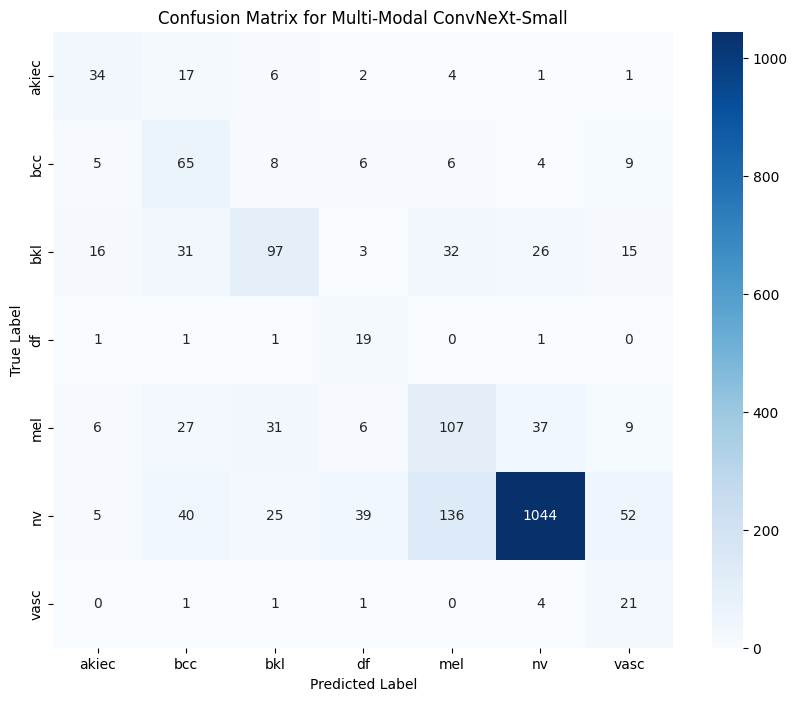

In [4]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

print("\nStarting multi-modal model training with ConvNeXt-Small...")
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    class_weight=class_weights_dict,
    callbacks=[early_stopping]
)

print("\nStarting final evaluation...")
loss, accuracy = model.evaluate(validation_dataset)

print("\n" + "="*40)
print("     Final Results on the Validation Set (Multi-modal ConvNeXt-Small)")
print("="*40)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy * 100:.2f}%")
print("="*40)

# Detailed Classification Report
print("\n" + "="*50)
print("     Detailed Classification Report")
print("="*50)
true_labels = np.concatenate([y for x, y in validation_dataset], axis=0)
predictions = model.predict(validation_dataset)
predicted_labels = np.argmax(predictions, axis=1)
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print(report)

# Confusion Matrix
print("\n" + "="*50)
print("     Confusion Matrix")
print("="*50)
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Multi-Modal ConvNeXt-Small')
plt.show()